In [4]:
import pandas as pd

# Chuẩn bị list để lưu dữ liệu đã lọc
chunks = []
chunksize = 1_000_000  # Đọc mỗi lần 1 triệu dòng

# Đọc file theo khối và lọc những dòng là purchase
for chunk in pd.read_csv('D:/VINAMILK/2019-Nov.csv', chunksize=chunksize):
    purchase_chunk = chunk[chunk['event_type'] == 'purchase']
    chunks.append(purchase_chunk)

# Gộp tất cả các purchase lại
df_nov = pd.concat(chunks, ignore_index=True)

# Lặp lại với file tháng 10
chunks_oct = []
for chunk in pd.read_csv('D:/VINAMILK/2019-Oct.csv', chunksize=chunksize):
    purchase_chunk = chunk[chunk['event_type'] == 'purchase']
    chunks_oct.append(purchase_chunk)

df_oct = pd.concat(chunks_oct, ignore_index=True)

# Gộp 2 tháng lại
df_purchase = pd.concat([df_nov, df_oct], ignore_index=True)

# Xem thử
print("Số dòng purchase:", df_purchase.shape)
df_purchase.head()


Số dòng purchase: (1659788, 9)


,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:41 UTC,purchase,13200605,2053013557192163841,furniture.bedroom.bed,NaN,566.30,559368633,d6034fa2-41fb-4ac0-9051-55ea9fc9147a
1,2019-11-01 00:01:04 UTC,purchase,1005161,2053013555631882655,electronics.smartphone,xiaomi,211.92,513351129,e6b7ce9b-1938-4e20-976c-8b4163aea11d
2,2019-11-01 00:04:51 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,128.42,562958505,0f039697-fedc-40fa-8830-39c1a024351d
3,2019-11-01 00:05:34 UTC,purchase,26401669,2053013563651392361,NaN,lucente,109.66,541854711,c41c44d5-ef9b-41b9-9cd6-8d96dda6e927
4,2019-11-01 00:06:33 UTC,purchase,1801881,2053013554415534427,electronics.video.tv,samsung,488.80,557746614,4d76d6d3-fff5-4880-8327-e9e57b618e0e


In [5]:
import pandas as pd

# Làm lại: Đảm bảo 'event_time' là datetime
df_purchase['event_time'] = pd.to_datetime(df_purchase['event_time'])

# Bỏ dòng không có giá
df_purchase = df_purchase.dropna(subset=['price'])

# Kiểm tra lần nữa
print("Số dòng còn lại sau làm sạch:", df_purchase.shape)


Số dòng còn lại sau làm sạch: (1659788, 9)


In [6]:
# Ngày phân tích = ngày cuối cùng trong dữ liệu
NOW = df_purchase['event_time'].max()

# Nhóm theo user_id
rfm = df_purchase.groupby('user_id').agg({
    'event_time': lambda x: (NOW - x.max()).days,       # Recency
    'user_session': 'nunique',                          # Frequency
    'price': 'sum'                                      # Monetary
}).reset_index()

# Đổi tên cột
rfm.columns = ['user_id', 'Recency', 'Frequency', 'Monetary']

# Kiểm tra kết quả
rfm.head()

,user_id,Recency,Frequency,Monetary
0,138340325,19,1,93.50
1,225644257,18,1,40.91
2,253299396,24,1,246.85
3,256164170,10,1,113.23
4,264649825,55,2,1240.04


In [7]:
# Chấm điểm theo phân vị (quantile)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5])
rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

# Gộp lại thành segment
rfm['RFM_Segment'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

# Phân loại nhóm khách hàng
def segment_customer(segment):
    if segment == '555':
        return 'VIP'
    elif segment.startswith('5'):
        return 'Mới mua nhiều'
    elif segment.endswith('5'):
        return 'Chi tiêu cao'
    elif segment.startswith('1'):
        return 'Nguy cơ rời bỏ'
    else:
        return 'Khác'

rfm['Customer_Type'] = rfm['RFM_Segment'].apply(segment_customer)

In [8]:
segment_summary = rfm['Customer_Type'].value_counts(normalize=True) * 100
print(segment_summary.round(2))

Customer_Type
Khác              47.48
Mới mua nhiều     17.10
Nguy cơ rời bỏ    16.99
Chi tiêu cao      13.91
VIP                4.53
Name: proportion, dtype: float64


In [9]:
# Gộp thông tin RFM vào df_purchase
df_merged = df_purchase.merge(rfm[['user_id', 'Customer_Type']], on='user_id', how='left')

# Đếm số lần mua mỗi loại sản phẩm theo nhóm khách
category_by_segment = df_merged.groupby(['Customer_Type', 'category_code']).size().reset_index(name='count')

# Top 10 sản phẩm mỗi nhóm
top_categories = category_by_segment.sort_values(['Customer_Type', 'count'], ascending=[True, False]).groupby('Customer_Type').head(5)

print(top_categories)

      Customer_Type                  category_code   count
91     Chi tiêu cao         electronics.smartphone  251206
95     Chi tiêu cao           electronics.video.tv   15688
84     Chi tiêu cao    electronics.audio.headphone   14913
66     Chi tiêu cao             computers.notebook   13473
90     Chi tiêu cao             electronics.clocks   11757
214            Khác         electronics.smartphone  159853
207            Khác    electronics.audio.headphone   24402
218            Khác           electronics.video.tv   15113
147            Khác  appliances.environment.vacuum   14695
167            Khác      appliances.kitchen.washer   12596
339   Mới mua nhiều         electronics.smartphone   75307
332   Mới mua nhiều    electronics.audio.headphone   10213
343   Mới mua nhiều           electronics.video.tv    5636
270   Mới mua nhiều  appliances.environment.vacuum    4525
338   Mới mua nhiều             electronics.clocks    4395
456  Nguy cơ rời bỏ         electronics.smartphone   587

In [ ]:
# Nhóm theo loại khách và thương hiệu
brand_by_segment = df_merged.groupby(['Customer_Type', 'brand']).agg({
    'price': 'sum',
    'user_id': 'nunique'
}).reset_index().rename(columns={'price': 'total_spent', 'user_id': 'unique_customers'})

# Top 5 thương hiệu mỗi nhóm
top_brands = brand_by_segment.sort_values(['Customer_Type', 'total_spent'], ascending=[True, False]).groupby('Customer_Type').head(5)

print(top_brands)

       Customer_Type    brand   total_spent  unique_customers
93      Chi tiêu cao    apple  1.361676e+08             62411
1360    Chi tiêu cao  samsung  3.363881e+07             30283
1681    Chi tiêu cao   xiaomi  5.152327e+06              7950
3       Chi tiêu cao     acer  3.187953e+06              2764
892     Chi tiêu cao       lg  3.147933e+06              3547
3457            Khác  samsung  2.358854e+07             83762
1838            Khác    apple  1.228806e+07             28072
3870            Khác   xiaomi  6.751191e+06             35110
2641            Khác   huawei  2.880313e+06             12779
2882            Khác       lg  2.167496e+06              6050
4017   Mới mua nhiều    apple  1.502357e+07             16267
5442   Mới mua nhiều  samsung  1.023132e+07             31540
5808   Mới mua nhiều   xiaomi  2.679438e+06             13974
4721   Mới mua nhiều   huawei  1.087419e+06              4671
4923   Mới mua nhiều       lg  7.570811e+05              1809
6943  Ng

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Gộp RFM vào df_purchase
df_viz = df_purchase.merge(rfm[['user_id', 'Customer_Type']], on='user_id', how='left')

# Bỏ NaN
df_viz = df_viz.dropna(subset=['Customer_Type', 'category_code', 'brand'])

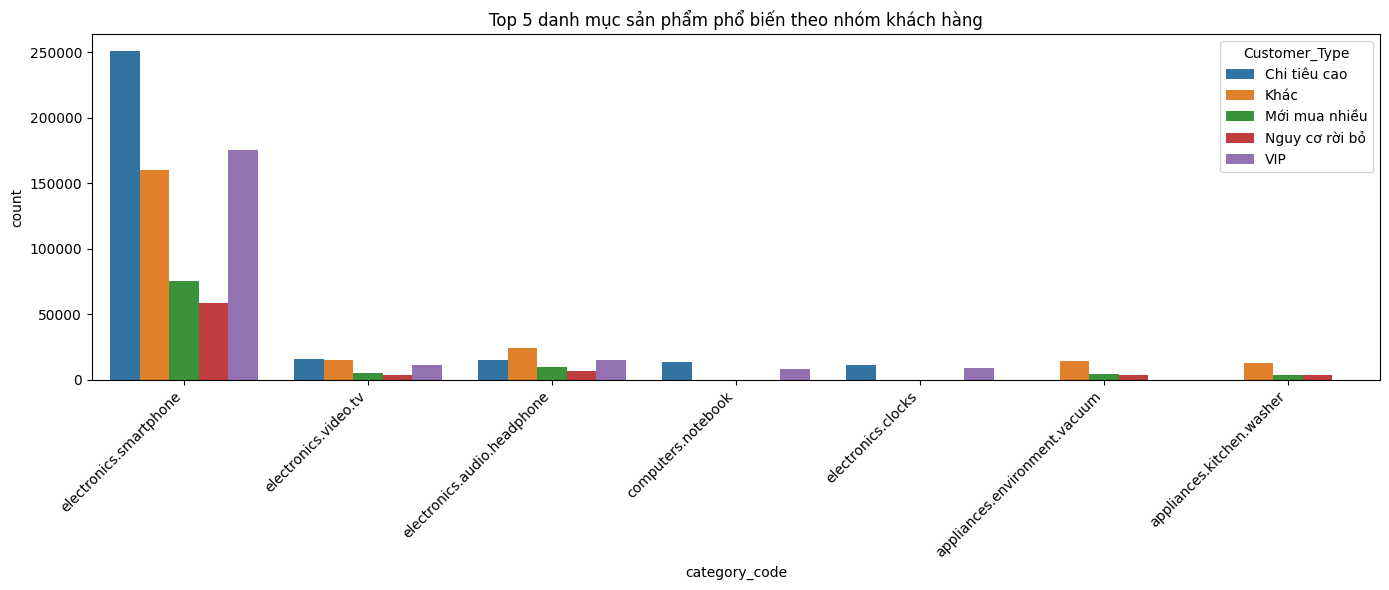

In [14]:
plt.figure(figsize=(14, 6))
top_cat = (
    df_viz.groupby(['Customer_Type', 'category_code'])
    .size()
    .reset_index(name='count')
    .sort_values(['Customer_Type', 'count'], ascending=[True, False])
    .groupby('Customer_Type')
    .head(5)
)

sns.barplot(
    data=top_cat,
    x='category_code', y='count',
    hue='Customer_Type'
)
plt.title("Top 5 danh mục sản phẩm phổ biến theo nhóm khách hàng")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


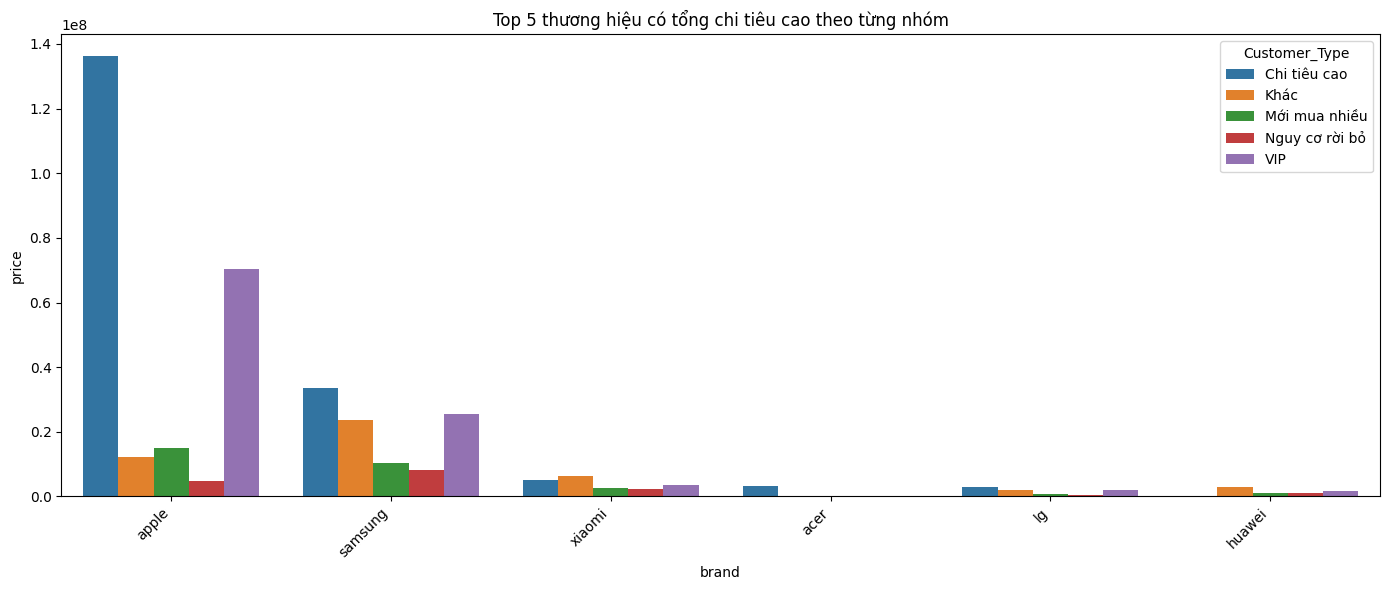

In [15]:
plt.figure(figsize=(14, 6))
top_brand = (
    df_viz.groupby(['Customer_Type', 'brand'])
    .agg({'price': 'sum'})
    .reset_index()
    .sort_values(['Customer_Type', 'price'], ascending=[True, False])
    .groupby('Customer_Type')
    .head(5)
)

sns.barplot(
    data=top_brand,
    x='brand', y='price',
    hue='Customer_Type'
)
plt.title("Top 5 thương hiệu có tổng chi tiêu cao theo từng nhóm")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [16]:

df_viz.to_csv('D:/VINAMILK/rfm_customer_behavior.csv', index=False)